In [1]:
def convert_percentage_to_float(df):
    for col in df.columns:
        df[col] = df[col].apply(lambda x: float(x.strip('%')) / 100 if isinstance(x, str) and '%' in x else x)
    return df

def to_numeric(s):
    if isinstance(s, (int,float)):
        return s
    # Remove unwanted characters
    cleaned = s.replace(',', '').replace('$', '').strip()
    if cleaned.replace('.', '').isdigit():  # If after removing '.' all characters are digits
        return float(cleaned) if '.' in cleaned else int(cleaned)
    return s  # If the string isn't numeric, return as is

def to_numeric_df(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str)
            df[col]= df[col].apply(to_numeric)
    return df

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('../data/training_data/REVL COOF VALUATION 08-2023.csv')

df = df[[c for c in df.columns if 'unnamed' not in c.lower()]]
x = [c.replace('\n','') for c in df.columns]
x = [c.strip() for c in x]
x = [c.replace(' ','_') for c in x]
x = [c.lower() for c in x]
df.columns = x

df.dropna(how='all', inplace=True)


df['naics'] = df['naics'].fillna('0')

df['naics'] = df['naics'].astype(int)

df = convert_percentage_to_float(df)
df = to_numeric_df(df)

df['term_yrs']=df['term']//12


x_df = df[['naics','loan_spread','loan_rate','strip_rate','original_balance','current_balance','term_yrs','term','age','rmos']]
y_df = df['valuation_multiple']

X = x_df
y = y_df

def get_naics_dummies(in_df:pd.DataFrame)->pd.DataFrame:
    temp = in_df.copy()
    temp['is_hotel'] = 0
    temp.loc[temp['naics']==721110, 'is_hotel'] = 1
    temp.columns = [str(c) for c in temp.columns]
    return temp.drop(columns='naics')

# Create dummy columns with all the categories observed in the entire dataset
X = get_naics_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_model = LinearRegression()

scaler = StandardScaler()

scaler.fit_transform(X_train, y_train)

print(X_train)

# Train the model on the training data
reg_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = reg_model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

     loan_spread  loan_rate  strip_rate  original_balance  current_balance   
82        0.0225     0.1075      0.0261        3653426.79       3653426.79  \
51        0.0200     0.1050      0.0281         832842.57        832842.57   
220       0.0100     0.0950      0.0036         640782.25        640782.25   
559       0.0200     0.1050      0.0217         972165.58        972165.58   
544       0.0200     0.1050      0.0123        2925000.00       2925000.00   
..           ...        ...         ...               ...              ...   
71        0.0275     0.1125      0.0311         261025.34        261025.34   
106       0.0125     0.0975      0.0048        3112500.00       3112500.00   
270       0.0200     0.1050      0.0104         401402.12        391096.33   
435       0.0150     0.1000      0.0048        1650000.00       1650000.00   
102       0.0200     0.1050      0.0178         367875.00        367875.00   

     term_yrs   term   age   rmos  is_hotel  
82       25.0  30

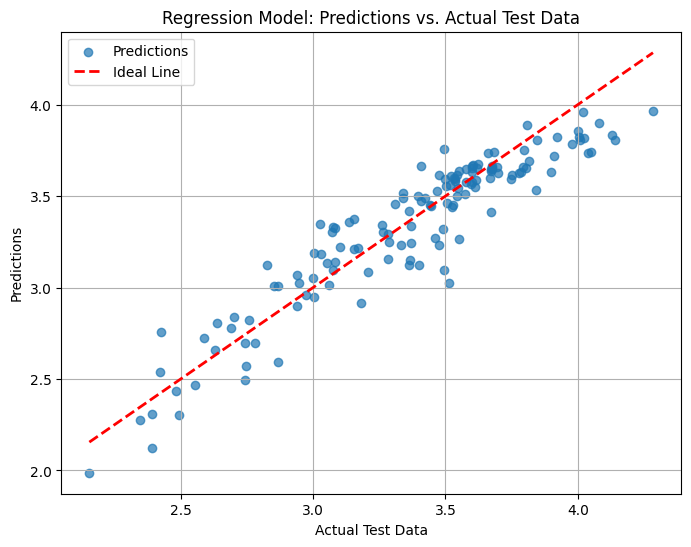

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the predictions vs the actual test data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2, label='Ideal Line')
plt.xlabel('Actual Test Data')
plt.ylabel('Predictions')
plt.title('Regression Model: Predictions vs. Actual Test Data')
plt.legend()
plt.grid(True)
plt.show()


Feature Importance Data:
            Feature  Coefficient  Absolute_Coefficient
0       loan_spread     2.046387              2.046387
1         loan_rate     2.046387              2.046387
2        strip_rate     0.432267              0.432267
3              rmos     0.209727              0.209727
4          is_hotel    -0.201837              0.201837
5              term    -0.199949              0.199949
6               age     0.177224              0.177224
7          term_yrs    -0.042952              0.042952
8   current_balance    -0.000001              0.000001
9  original_balance     0.000001              0.000001


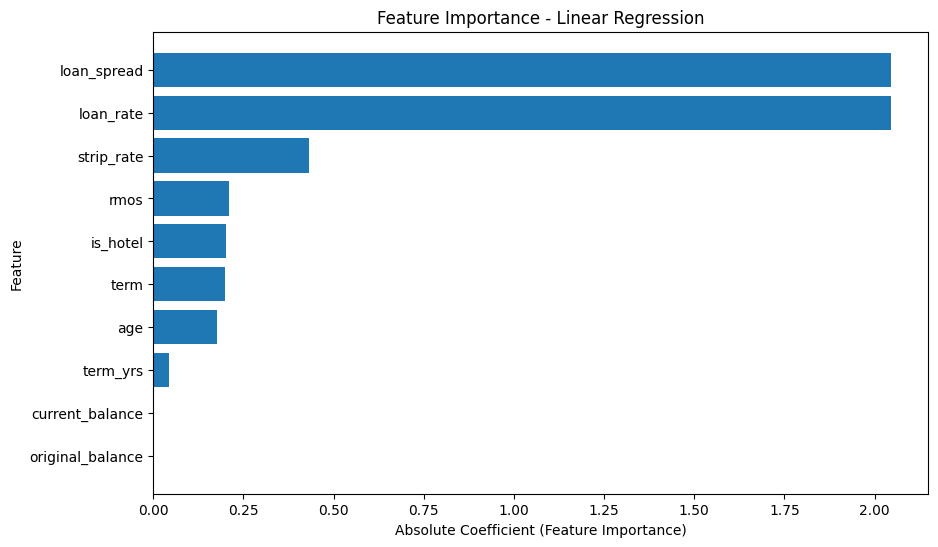

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already trained the 'reg_model' linear regression model

# Get the coefficients (weights) of the linear regression model
coefficients = reg_model.coef_

# Get the feature names
feature_names = X.columns

# Create a DataFrame to store feature names and their corresponding coefficients
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Calculate the absolute coefficients (feature importance)
feature_importance_df['Absolute_Coefficient'] = feature_importance_df['Coefficient'].abs()

# Sort the features based on their absolute coefficients to get feature importance
feature_importance_df = feature_importance_df.sort_values(by='Absolute_Coefficient', ascending=False).reset_index(drop=True)

# Display the DataFrame containing feature importance data
print("Feature Importance Data:")
print(feature_importance_df)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Absolute_Coefficient'])
plt.xlabel('Absolute Coefficient (Feature Importance)')
plt.ylabel('Feature')
plt.title('Feature Importance - Linear Regression')
plt.gca().invert_yaxis()
plt.show()


In [5]:
col_order = X.columns

## Input new file to make predictions on below:

In [18]:
import sqlalchemy as sa

import warnings
warnings.filterwarnings('ignore')
import os
from dotenv import load_dotenv
load_dotenv()
engine = sa.create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
    .format(host=os.getenv('host'), db=os.getenv('db'), user=os.getenv('uname'), pw=os.getenv('password')))
    
fhn = pd.read_csv('../data/fhn_8.23.23.csv')

fhn_1 = fhn[fhn.columns[1:]]

fhn_1['is_hotel'] = 0

fhn_1.loc[fhn_1['naics'] == ('721110'), 'is_hotel'] = 1

fhn_1 = fhn_1[fhn_1.columns[1:]]

fhn_1['term_yrs'] = fhn_1['term'] // 12

fhn_1 = fhn_1[col_order]

naics_tbl = pd.read_csv('../data/naics_22/naics_lookup.csv')

fhn = fhn.merge(naics_tbl, left_on='naics', right_on='Code', how='left')
fhn = fhn.drop(columns=[c for c in fhn.columns if 'unnamed' in c.lower()])
fhn

,gp,naics,loan_spread,loan_rate,strip_rate,original_balance,current_balance,term,age,rmos,Code,CodeText
0,5000879101,722410,0.0275,0.1125,0.01730,740376.32,740376.32,301,2.800000,298.200000,722410.0,Drinking Places (Alcoholic Beverages)
1,5095219104,238150,0.0200,0.1050,0.00980,1668750.00,1668750.00,301,2.600000,298.400000,238150.0,Glass and Glazing Contractors
2,5102699107,459110,0.0225,0.1075,0.01230,1109250.00,1109250.00,301,2.833333,298.166667,459110.0,Sporting Goods Retailers
3,5081229106,812112,0.0225,0.1075,0.01230,630000.00,630000.00,301,2.833333,298.166667,812112.0,Beauty Salons
4,5088359102,238990,0.0225,0.1075,0.01230,521250.00,521250.00,301,2.933333,298.066667,238990.0,All Other Specialty Trade Contractors
...,...,...,...,...,...,...,...,...,...,...,...,...
168,1520289107,713940,0.0225,0.1075,0.01530,1106506.06,1106506.06,301,6.766667,294.233333,713940.0,Fitness and Recreational Sports Centers
169,1476149102,445320,0.0100,0.0950,0.00280,1249270.50,1249270.50,301,7.566667,293.433333,445320.0,"Beer, Wine, and Liquor Retailers"
170,5886838908,311999,0.0275,0.1125,0.04105,1602255.11,1602255.11,187,27.866667,159.133333,311999.0,All Other Miscellaneous Food Manufacturing
171,3033369109,713990,0.0275,0.1125,0.01480,1275000.00,1275000.00,312,17.000000,295.000000,713990.0,All Other Amusement and Recreation Industries


In [19]:
fhn_pred = reg_model.predict(fhn_1)

In [22]:
fhn['predicted_mult'] = fhn_pred

In [32]:
fhn[fhn['CodeText'].isna()]

,gp,naics,loan_spread,loan_rate,strip_rate,original_balance,current_balance,term,age,rmos,Code,CodeText,predicted_mult
6,4983199104,447110,0.0200,0.1050,0.00980,2930250.00,2930250.00,300,2.466667,297.533333,NaN,NaN,3.820283
13,5117979100,811100,0.0250,0.1100,0.01480,650475.00,650475.00,300,2.133333,297.866667,NaN,NaN,3.891946
35,4297129105,445310,0.0250,0.1100,0.01540,509822.31,509822.31,300,11.100000,288.900000,NaN,NaN,3.603120
48,5065599101,457117,0.0175,0.1025,0.00730,1512871.71,1512871.71,300,3.000000,297.000000,NaN,NaN,3.815387
130,4650219110,445310,0.0200,0.1050,0.02655,1194172.54,1194172.54,120,7.133333,112.866667,NaN,NaN,2.589182
146,4398079102,0,0.0300,0.1150,0.01730,1506684.55,1506684.55,301,8.933333,292.066667,NaN,NaN,3.687901
157,4285319106,445310,0.0275,0.1125,0.01290,517990.39,517990.39,301,3.666667,297.333333,NaN,NaN,3.863517


In [34]:
fhn.loc[fhn['naics']==447110,'CodeText'] = 'Gasoline Stations with Convenience Stores'
fhn.loc[fhn['naics']==445310,'CodeText'] = 'Beer, Wine, and Liquor Stores'
fhn.loc[fhn['naics']==811100,'CodeText'] = 'Not a Valid NAICS Code'
fhn.loc[fhn['naics']==457117,'CodeText'] = 'Not a Valid NAICS Code'
fhn.loc[fhn['naics']==0,'CodeText'] = 'Not a Valid NAICS Code'


In [35]:
fhn

,gp,naics,loan_spread,loan_rate,strip_rate,original_balance,current_balance,term,age,rmos,Code,CodeText,predicted_mult
0,5000879101,722410,0.0275,0.1125,0.01730,740376.32,740376.32,301,2.800000,298.200000,722410.0,Drinking Places (Alcoholic Beverages),3.889861
1,5095219104,238150,0.0200,0.1050,0.00980,1668750.00,1668750.00,301,2.600000,298.400000,238150.0,Glass and Glazing Contractors,3.846867
2,5102699107,459110,0.0225,0.1075,0.01230,1109250.00,1109250.00,301,2.833333,298.166667,459110.0,Sporting Goods Retailers,3.859971
3,5081229106,812112,0.0225,0.1075,0.01230,630000.00,630000.00,301,2.833333,298.166667,812112.0,Beauty Salons,3.868002
4,5088359102,238990,0.0225,0.1075,0.01230,521250.00,521250.00,301,2.933333,298.066667,238990.0,All Other Specialty Trade Contractors,3.866574
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,1520289107,713940,0.0225,0.1075,0.01530,1106506.06,1106506.06,301,6.766667,294.233333,713940.0,Fitness and Recreational Sports Centers,3.733470
169,1476149102,445320,0.0100,0.0950,0.00280,1249270.50,1249270.50,301,7.566667,293.433333,445320.0,"Beer, Wine, and Liquor Retailers",3.648512
170,5886838908,311999,0.0275,0.1125,0.04105,1602255.11,1602255.11,187,27.866667,159.133333,311999.0,All Other Miscellaneous Food Manufacturing,2.385779
171,3033369109,713990,0.0275,0.1125,0.01480,1275000.00,1275000.00,312,17.000000,295.000000,713990.0,All Other Amusement and Recreation Industries,3.482888


In [36]:
fhn.to_csv('../data/predictions/fhn_predictions.csv')